In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import Normalize
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
import numpy as np
from numpy.random import mtrand
from utils import *
from syngenerator import *
from enum import IntEnum

class HoleType(IntEnum):
    NONE = 100,
    IN_HOLE = 101,
    OUT_HOLE = 102,


def sample_hole(n_samples, rd:np.random.RandomState, holeType:HoleType):
    
    parameters = rd.uniform(size=(2, n_samples)) * np.array([[1.0], [1.0]])
    
    if holeType == HoleType.OUT_HOLE:
        corners = np.array(
                [[i, j] for i in range(3) for j in range(3)]
            )
        corners = np.delete(corners, 4, axis=0)
        corner_index = rd.choice(8, n_samples)
        return (corners[corner_index].T + parameters) / 3.0

    elif holeType == HoleType.IN_HOLE:
        return (np.array([[1.0],[1.0]]) + parameters) / 3.0

    elif holeType == HoleType.NONE:
        return parameters

    raise ValueError(f"Unsupported hole tpye '{holeType}'")


def sample_plane(n_samples, seed, hole=HoleType.NONE):

    rd = mtrand.RandomState(seed)

    X = np.zeros((n_samples, 3))

    X[:, 0], X[:, 1] = sample_hole(n_samples, rd, hole)

    return X, X[:, 0]


def sample_swiss_roll(n_samples, seed, hole=HoleType.NONE):

    rd = mtrand.RandomState(seed)

    sample_t, sample_y = sample_hole(n_samples, rd, hole)
    
    X = np.zeros((n_samples, 3))

    u = 3
    t = np.pi * (0.0 + u * (sample_t + 0.5))
    max_t = np.pi * (1.0 + u * 1)
    
    X[:,1] = sample_y
    X[:,0] = t * np.cos(t) / max_t
    X[:,2] = t * np.sin(t) / max_t

    return X, sample_t


def sample_cylinder(n_samples, seed, hole=HoleType.NONE):

    rd = mtrand.RandomState(seed)

    sample_t, sample_y = sample_hole(n_samples, rd, hole)
    
    X = np.zeros((n_samples, 3))

    t = 2 * np.pi * sample_t
    
    X[:,1] = sample_y
    X[:,0] = np.cos(t) * 0.5
    X[:,2] = np.sin(t) * 0.5

    return X, sample_t


def sample_s_curve(n_samples, seed, hole=HoleType.NONE):

    rd = mtrand.RandomState(seed)

    sample_t, sample_y = sample_hole(n_samples, rd, hole) - 0.5
    
    X = np.zeros((n_samples, 3))

    t = 3.0 * np.pi * sample_t

    X[:,1] = sample_y
    X[:,0] = np.sin(t) * 0.5
    X[:,2] = np.sign(t) * (np.cos(t) - 1) * 0.25

    return X, sample_t


def show_proj(P_train, P_test, y_train, y_test, labeled=False):
    
    fig = plt.figure(figsize=(5,2.5))
    
    ax=fig.add_subplot(1,2,1)
    ax.scatter(P_train[:,0],P_train[:,1],c=y_train,cmap='tab10' if labeled else 'coolwarm', s=10,alpha=0.85, norm=Normalize(0,10) if labeled else None)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('train')

    ax=fig.add_subplot(1,2,2)
    ax.scatter(P_test[:,0],P_test[:,1],c=y_test,cmap='tab10' if labeled else 'coolwarm',s=10,alpha=0.85, norm=Normalize(0,10) if labeled else None)
    ax.set_xlim(np.min(P_train[:,0]), np.max(P_train[:,0]))
    ax.set_ylim(np.min(P_train[:,1]), np.max(P_train[:,1]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('test')
    fig.tight_layout()
    
    plt.show()


# Plane - Interpolation - without Cluster

0.9999311470188161
X_train: (1000, 4), X_test: (50, 4)


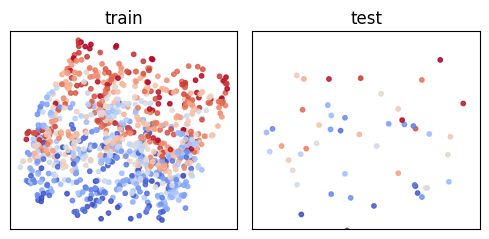

In [ ]:
n_train, n_test = 1000, 50
n_dims = 4

rd = mtrand.RandomState(0)

X_train = rd.uniform(0,1,(n_train,n_dims))
X_train[:,:3], y_train = sample_plane(n_train, seed=24)

print(np.max(X_train))

X_test = rd.uniform(0,1,(n_test,n_dims))
X_test[:, :3], y_test  = sample_plane(n_test,  seed=42)

p = Isomap(n_components=2)
P_train = p.fit_transform(X_train)
P_test = p.transform(X_test)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
show_proj(P_train, P_test, y_train, y_test)

save_dataset("datasets/synth/plane_interp_noclu.h5", X_train, X_test, y_train, y_test)

# Plane - Interpolation - with Clusters

100%|██████████| 800/800 [00:00<00:00, 26094.53it/s]


X_train: (1200, 4), X_test: (800, 4)


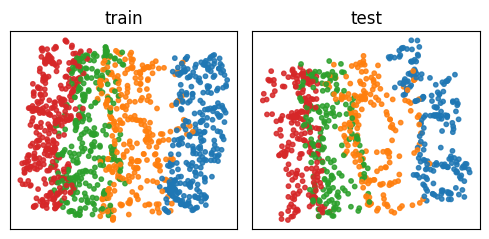

In [56]:


gen_p_i_train = SynGeneratorParser.load('org_datasets/syn_org_data/plane_inter_train.json')
gen_p_i_test = SynGeneratorParser.load('org_datasets/syn_org_data/plane_inter_test.json')
X_train, y_train = gen_p_i_train.generate(888)
X_test , y_test  = gen_p_i_test.generate(999)

p = Isomap(n_components=2)
P_train = p.fit_transform(X_train)
P_test = p.fit_transform(X_test)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
show_proj(P_train, P_test, y_train, y_test,True)

save_dataset("datasets/synth/plane_interp_clu.h5", X_train, X_test, y_train, y_test)

# Plane - Extrapolation - without Cluster

X_train: (1000, 4), X_test: (5, 4)


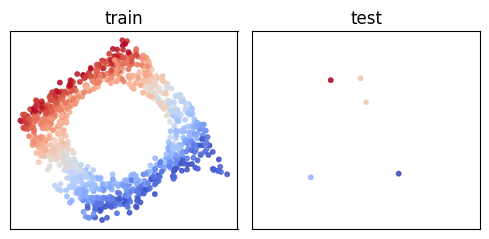

In [ ]:
n_train, n_test = 1000, 5
n_dims = 4

rd = mtrand.RandomState(2)

X_train = rd.uniform(0,1,(n_train,n_dims))
X_train[:,:3], y_train = sample_plane(n_train, seed=10, hole=HoleType.OUT_HOLE)

X_test = rd.uniform(0,1,(n_test,n_dims))
X_test[:, :3], y_test = sample_plane(n_test,  seed=30, hole=HoleType.IN_HOLE)

p = Isomap(n_components=2)
P_train = p.fit_transform(X_train)
P_test = p.transform(X_test)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
show_proj(P_train, P_test, y_train, y_test)

# save_dataset("datasets/synth/plane_extrap_noclu.h5", X_train, X_test, y_train, y_test)

In [ ]:
from methods.methods import *
import traceback
from tqdm import tqdm

m = Methods(verbose=False, gpu_accel=True)

# methods = ['mimds']
methods = m.available()

for method_name in tqdm(methods):
    try:
        print(f"*** Method {method_name} running")
        method = m.get(method_name)
        method.fit(X_train)
        p_train = method.transform(X_train)
        p_test = method.transform_oos(X_test)

    except:
        print(f"Method '{method_name}' failed")
        p_train = np.zeros((X_train.shape[0],2))
        p_test = np.zeros((X_test.shape[0],2))

        print(traceback.print_exc())
    
    save_projection(f"org_datasets/syn_org_data/{method_name}_train.csv", p_train)
    save_projection(f"org_datasets/syn_org_data/{method_name}_test.csv", p_test)


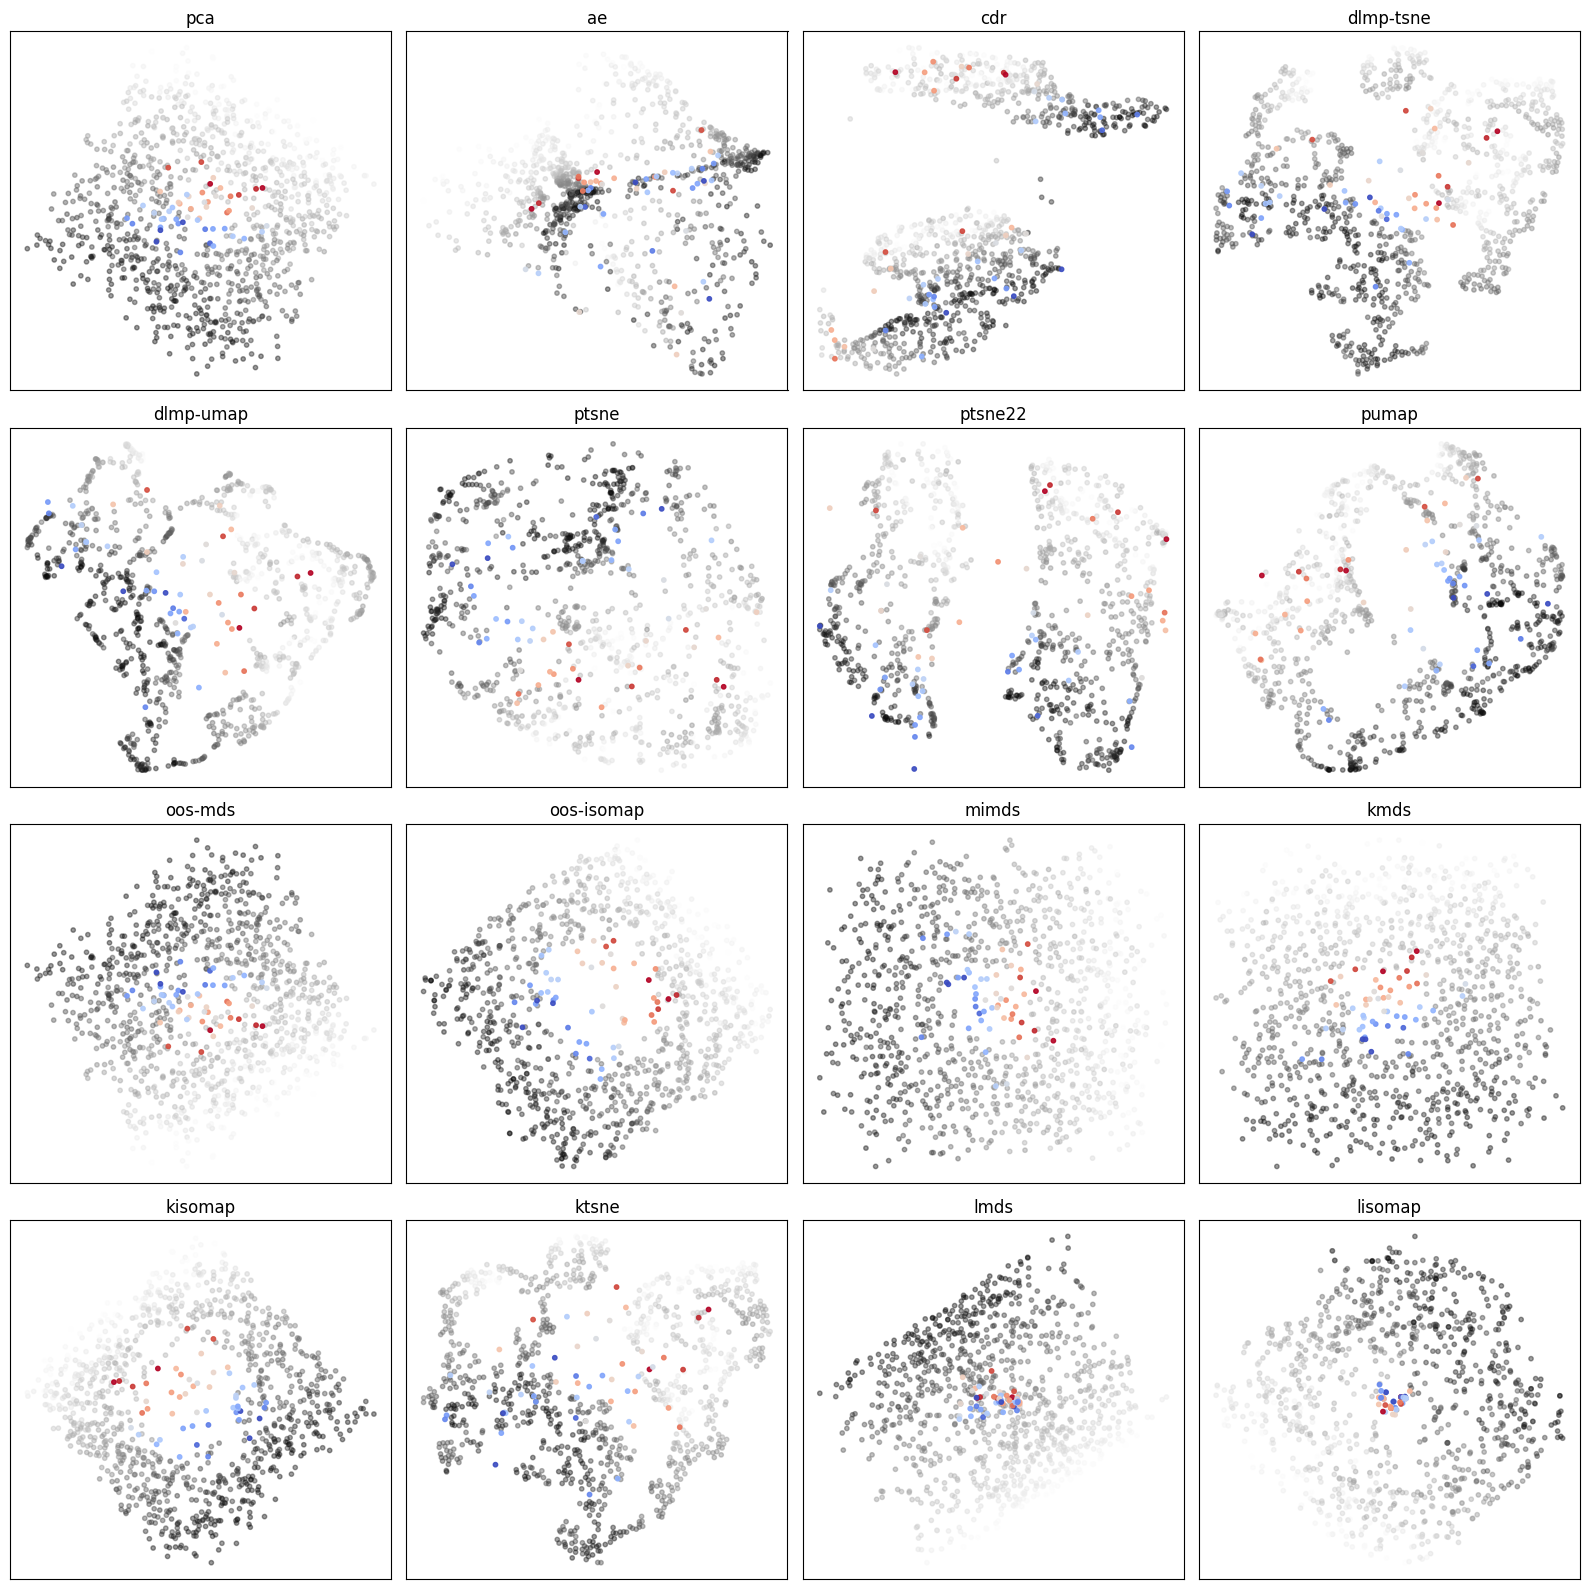

In [ ]:

ncols = min(4, len(methods))
nrows = int(np.ceil(len(methods) / ncols))

fig, ax = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))

for i, method_name in enumerate(methods):

    r = i // ncols
    c = i % ncols
    p_train = load_projection(f"org_datasets/syn_org_data/{method_name}_train.csv")
    p_test  = load_projection(f"org_datasets/syn_org_data/{method_name}_test.csv")
    
    axes = ax[r, c] if nrows > 1 else ax[i] if ncols > 1 else ax

    axes.set_title(methods[i])
    
    # axes.scatter(p[:,0], p[:,1], c=y_test, cmap='tab10', marker='o', s=10, alpha=0.9, norm=Normalize(vmin=0, vmax=9))
    axes.scatter(p_train[:,0], p_train[:,1], c=y_train, cmap='gray', marker='o', s=10, alpha=0.4)
    axes.scatter(p_test[:,0], p_test[:,1], c=y_test, cmap='coolwarm', marker='o', s=10, alpha=0.9)

    axes.set_xticks([])
    axes.set_yticks([])

fig.tight_layout()


In [ ]:
from metrics import *
import pandas as pd

metrics = Metrics()

metrics_name = metrics.available()

metdf = pd.DataFrame(columns=metrics_name, index=methods)

for method_name in methods:
    p_train = load_projection(f"org_datasets/syn_org_data/{method_name}_train.csv")
    p_test = load_projection(f"org_datasets/syn_org_data/{method_name}_test.csv")

    try:
        metrics.update_metrics(X_train, p_train, X_test, p_test, y_train, y_test)
    except:
        traceback.print_exc()
        continue

    for metric_idx, metric_name in enumerate(metrics_name):
        try:
            result, full_name = metrics.run_single(metric_name)
            metdf.loc[method_name, metric_name] = result
        except:
            traceback.print_exc()
            continue

print(metdf)

# Plane - Extrapolation - with Cluster

In [2]:


gen_p_i_train = SynGeneratorParser.load('org_datasets/syn_org_data/plane_etxra_train.json')
gen_p_i_test = SynGeneratorParser.load('org_datasets/syn_org_data/plane_extra_test.json')
X_train, y_train = gen_p_i_train.generate(111)
X_test , y_test  = gen_p_i_test.generate(222)

p = Isomap(n_components=2)
P_train = p.fit_transform(X_train)
P_test = p.fit_transform(X_test)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
show_proj(P_train, P_test, y_train, y_test,True)

save_dataset("datasets/synth/plane_interp_clu.h5", X_train, X_test, y_train, y_test)

FileNotFoundError: [Errno 2] No such file or directory: 'org_datasets/syn_org_data/plane_etxra_train.json'